In [1]:
# 分析时间：2013年1月1日-2022年12月31日，总共10年时间
# 但是在做特征分析的时候，可以把数据拉长。多搞一年：即2012-01-01至2022-12-31
feature_start_date_str = "2011-01-01"
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_data(raw_df, date_benchmark, feature_start_date, end_date):
    clean_df = raw_df[(raw_df['Date']>=feature_start_date) & (raw_df['Date']<=end_date)].reset_index(drop=True)
    investment_fac_df = pd.merge(date_benchmark, clean_df, on="Date", how="left")
    # 采用向下填充
    clean_df = clean_df.fillna(method='ffill')
    return clean_df

def plot_features(clean_df, col_name_list, title="Investment in fixed assets completed"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for temp_col in col_name_list:
        ax.plot(clean_df['Date'], clean_df[temp_col], label=temp_col)
        

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    fig.autofmt_xdate()
    plt.tight_layout()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [4]:
feature_start_date = datetime.datetime.strptime(feature_start_date_str, "%Y-%m-%d")
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(feature_start_date, start_date, end_date)

2011-01-01 00:00:00 2012-01-01 00:00:00 2022-12-31 00:00:00


In [5]:
# 取出目标数据
# 到期收益率
raw_yield_to_maturity_df = pd.read_excel('./data/国债到期收益率.xlsx')
raw_yield_to_maturity_df = raw_yield_to_maturity_df.rename(columns={'指标名称': 'Date',
       '国债到期收益率:6个月': "6M", '国债到期收益率:1年': "1Y", '国债到期收益率:2年': "2Y", '国债到期收益率:3年': "3Y",
       '国债到期收益率:4年': "4Y", '国债到期收益率:5年': "5Y", '国债到期收益率:6年': "6Y", '国债到期收益率:7年': "7Y", 
        '国债到期收益率:8年': "8Y",'国债到期收益率:9年': "9Y", '国债到期收益率:10年': "10Y", '国债到期收益率:15年': "15Y", 
        '国债到期收益率:20年': "20Y", '国债到期收益率:30年': "30Y"})
raw_yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2008-07-01,3.2769,3.4474,3.8065,4.0301,4.1697,4.3093,4.3498,4.3903,4.4292,4.4682,4.5072,4.9618,4.9639,4.9498
1,2008-07-02,3.4055,3.5461,3.8015,3.9506,4.0883,4.2260,4.3019,4.3778,4.4282,4.4787,4.5291,4.9442,4.9462,4.9501
2,2008-07-03,3.3343,3.4972,3.8687,3.9820,4.1085,4.2350,4.3163,4.3976,4.4436,4.4896,4.5356,4.9453,4.9469,4.9501
3,2008-07-04,3.3397,3.4763,3.8179,3.9854,4.1031,4.2209,4.3183,4.4157,4.4618,4.5080,4.5542,4.9469,4.9479,4.9501
4,2008-07-07,3.3679,3.4796,3.8138,3.9561,4.0850,4.2140,4.2849,4.3559,4.4215,4.4871,4.5527,4.9226,4.9285,4.9404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023-03-13,2.1958,2.2696,2.4373,2.5289,2.6127,2.6965,2.7655,2.8345,2.8473,2.8600,2.8728,3.0310,3.1147,3.2772
3668,2023-03-14,2.1950,2.2655,2.4475,2.5215,2.6046,2.6877,2.7591,2.8305,2.8417,2.8528,2.8640,3.0196,3.1047,3.2692
3669,2023-03-15,2.2050,2.2638,2.4432,2.5278,2.6121,2.6963,2.7663,2.8363,2.8474,2.8584,2.8695,3.0152,3.1033,3.2700
3670,2023-03-16,2.1799,2.2598,2.4193,2.5182,2.5953,2.6723,2.7483,2.8242,2.8342,2.8441,2.8541,2.9998,3.0857,3.2503


In [6]:
# 按特征长度选择数据
yield_to_maturity_df = raw_yield_to_maturity_df[(raw_yield_to_maturity_df['Date']>=feature_start_date)
                                                & (raw_yield_to_maturity_df['Date']<=end_date)].reset_index(drop=True)
yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2011-01-04,2.9635,3.0310,3.3571,3.3839,3.4591,3.5343,3.6066,3.6790,3.7370,3.7951,3.8531,4.0629,4.1640,4.2839
1,2011-01-05,2.9262,3.0047,3.1834,3.2891,3.3696,3.4500,3.5466,3.6432,3.6993,3.7553,3.8113,4.0108,4.1683,4.2554
2,2011-01-06,2.6401,2.8361,3.1205,3.2438,3.3567,3.4696,3.5691,3.6686,3.7146,3.7607,3.8067,4.0104,4.1645,4.2528
3,2011-01-07,2.6055,2.7599,3.1324,3.3165,3.3916,3.4667,3.5586,3.6505,3.7163,3.7820,3.8478,4.0208,4.1638,4.2649
4,2011-01-10,2.5607,2.7767,3.0750,3.2557,3.3469,3.4381,3.5293,3.6205,3.6891,3.7578,3.8264,4.0104,4.1569,4.2575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,2.1778,2.2398,2.3669,2.4616,2.5396,2.6175,2.7175,2.8175,2.8249,2.8324,2.8398,2.9777,3.0579,3.2225
2989,2022-12-27,2.2125,2.2615,2.3889,2.4898,2.5777,2.6656,2.7526,2.8395,2.8475,2.8556,2.8636,3.0014,3.0676,3.2182
2990,2022-12-28,2.2398,2.2732,2.4056,2.4746,2.5771,2.6795,2.7595,2.8395,2.8496,2.8598,2.8699,3.0078,3.0679,3.2125
2991,2022-12-29,2.1737,2.1952,2.3605,2.4405,2.5415,2.6425,2.7314,2.8202,2.8255,2.8309,2.8362,2.9741,3.0459,3.2021


In [7]:
date_benchmark = yield_to_maturity_df[["Date"]]
date_benchmark

,Date
0,2011-01-04
1,2011-01-05
2,2011-01-06
3,2011-01-07
4,2011-01-10
...,...
2988,2022-12-26
2989,2022-12-27
2990,2022-12-28
2991,2022-12-29


## 货币与财政政策

Monetary and fiscal policy

In [8]:
#货币
raw_currency_df = pd.read_excel("./data/features/货币.xlsx")
raw_currency_df = raw_currency_df.rename(columns={
    '指标名称': "Date", '中国:M0': "CN_M0", '中国:M0:同比': "CN_M0_MOM", '中国:M1': "CN_M1", 
    '中国:M1:同比': "CN_M1_MOM", '中国:M2': "CN_M2", '中国:M2:同比': "CN_M2_MOM",
       '中国:社会融资规模:当月值': "CN_SFS_M", '中国:社会融资规模存量': "CN_SSFS", 
    '中国:社会融资规模存量:同比': "CN_SSFS_MOM"
})
raw_currency_df

,Date,CN_M0,CN_M0_MOM,CN_M1,CN_M1_MOM,CN_M2,CN_M2_MOM,CN_SFS_M,CN_SSFS,CN_SSFS_MOM
0,1978-12-31,212.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-12-31,267.70,26.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-12-31,346.20,29.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-12-31,396.30,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1982-12-31,439.10,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
339,2022-10-31,98416.71,14.4,662140.99,5.8,2612914.57,11.8,9134.0,341.42,10.3
340,2022-11-30,99740.12,14.1,667042.61,4.6,2647008.48,12.4,19837.0,343.19,10.0
341,2022-12-31,104706.03,15.3,671674.76,3.7,2664320.84,11.8,13058.0,344.21,9.6
342,2023-01-31,114601.30,7.9,655214.16,6.7,2738072.06,12.6,59840.0,350.93,9.4


In [9]:
currency_df = clean_data(raw_currency_df, date_benchmark, feature_start_date, end_date)
currency_df

,Date,CN_M0,CN_M0_MOM,CN_M1,CN_M1_MOM,CN_M2,CN_M2_MOM,CN_SFS_M,CN_SSFS,CN_SSFS_MOM
0,2011-01-31,58063.94,42.5,261765.01,13.6,733884.83,17.2,17560.0,NaN,NaN
1,2011-02-28,47270.24,10.3,259200.50,14.5,736130.86,15.7,6468.0,NaN,NaN
2,2011-03-31,44845.22,14.8,266255.48,15.0,758130.88,16.6,18212.0,NaN,NaN
3,2011-04-30,45489.03,14.7,266766.91,12.9,757384.56,15.3,13673.0,NaN,NaN
4,2011-05-31,44602.83,15.4,269289.63,12.7,763409.22,15.1,10854.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
139,2022-08-31,97231.03,14.3,664604.85,6.1,2595068.27,12.2,24712.0,337.22,10.5
140,2022-09-30,98672.06,13.6,664535.17,6.4,2626600.92,12.1,35411.0,340.65,10.6
141,2022-10-31,98416.71,14.4,662140.99,5.8,2612914.57,11.8,9134.0,341.42,10.3
142,2022-11-30,99740.12,14.1,667042.61,4.6,2647008.48,12.4,19837.0,343.19,10.0


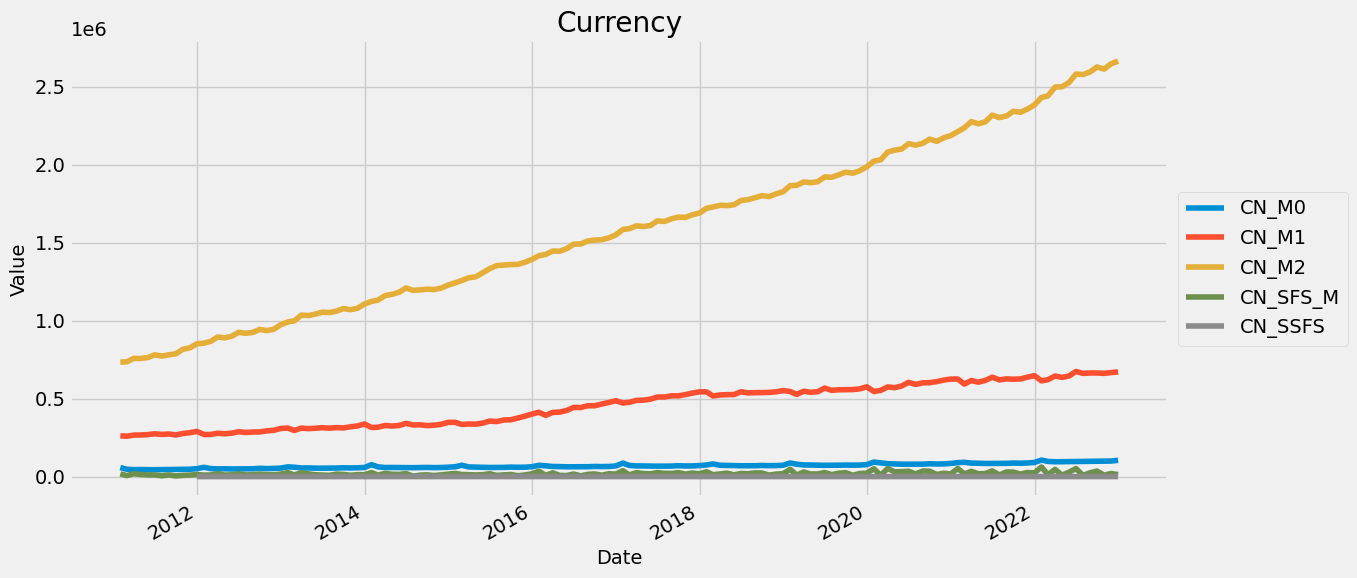

In [10]:
plot_features(currency_df, ['CN_M0','CN_M1', 'CN_M2', 'CN_SFS_M', 'CN_SSFS'], title="Currency")

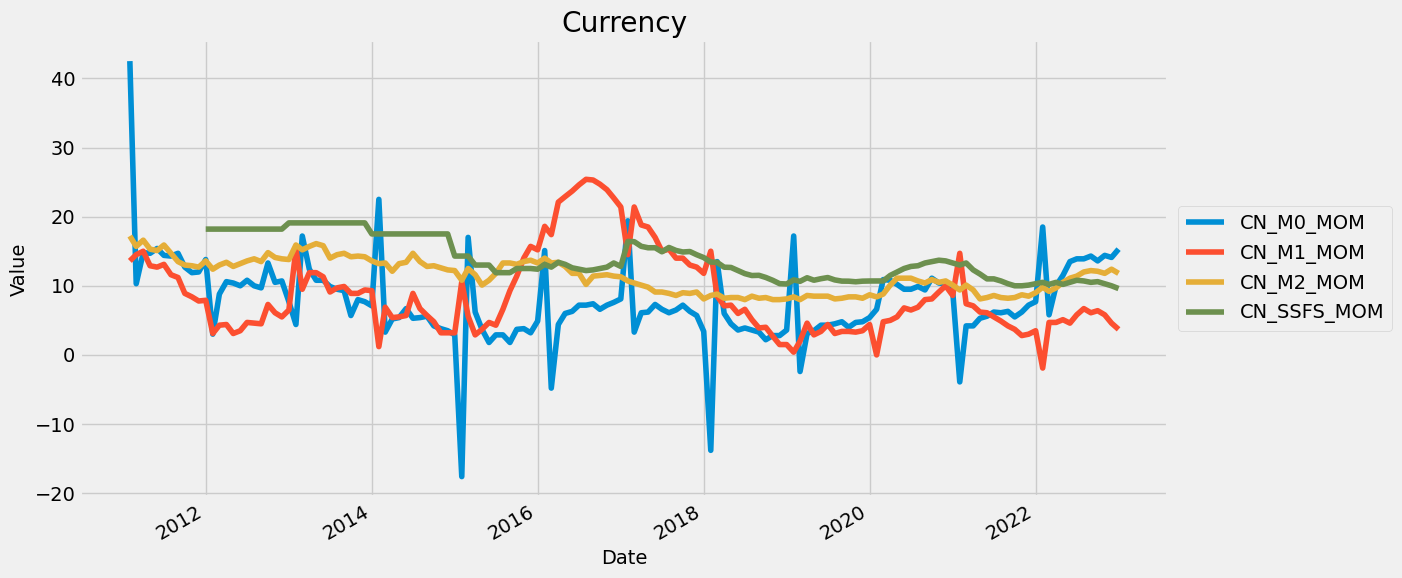

In [11]:
plot_features(currency_df, ['CN_M0_MOM','CN_M1_MOM', 'CN_M2_MOM', 'CN_SSFS_MOM'], title="Currency")

## 人民币存款基准利率
Benchmark interest rate for RMB deposits

In [12]:
raw_deposit_benchmark_df = pd.read_excel("./data/features/人民币存款基准利率.xlsx")
raw_deposit_benchmark_df = raw_deposit_benchmark_df.rename(columns={
  '指标名称': "Date", '中国:活期存款利率': "CN_Deposit_Demand", '中国:定期存款利率:3个月': "CN_Deposit_3M", 
    '中国:定期存款利率:6个月': "CN_Deposit_6M",
       '中国:定期存款利率:1年(整存整取)': "CN_Deposit_1Y", '中国:定期存款利率:2年(整存整取)': "CN_Deposit_2Y", 
    '中国:定期存款利率:3年(整存整取)': "CN_Deposit_3Y"
})
raw_deposit_benchmark_df

,Date,CN_Deposit_Demand,CN_Deposit_3M,CN_Deposit_6M,CN_Deposit_1Y,CN_Deposit_2Y,CN_Deposit_3Y
0,1949-08-10,60.00,NaN,168.00,252.00,NaN,NaN
1,1950-04-10,43.20,NaN,86.40,156.00,NaN,NaN
2,1950-10-20,12.60,NaN,31.20,34.80,NaN,NaN
3,1951-12-01,9.00,NaN,22.80,31.20,NaN,NaN
4,1952-09-15,5.40,NaN,12.60,14.40,NaN,NaN
5,1958-10-01,2.88,NaN,6.12,7.92,NaN,NaN
6,1959-01-01,2.16,NaN,3.60,4.80,NaN,NaN
7,1959-07-01,2.16,NaN,4.68,6.12,NaN,6.504
8,1965-06-01,2.16,NaN,3.24,3.96,NaN,NaN
9,1971-10-01,2.16,NaN,NaN,3.24,NaN,NaN


In [13]:
deposit_benchmark_df = clean_data(raw_deposit_benchmark_df, date_benchmark, feature_start_date, end_date)
deposit_benchmark_df.head()

,Date,CN_Deposit_Demand,CN_Deposit_3M,CN_Deposit_6M,CN_Deposit_1Y,CN_Deposit_2Y,CN_Deposit_3Y
0,2011-02-09,0.40,2.60,2.80,3.00,3.90,4.50
1,2011-04-06,0.50,2.85,3.05,3.25,4.15,4.75
2,2011-07-07,0.50,3.10,3.30,3.50,4.40,5.00
3,2012-06-08,0.40,2.85,3.05,3.25,4.10,4.65
4,2012-07-06,0.35,2.60,2.80,3.00,3.75,4.25


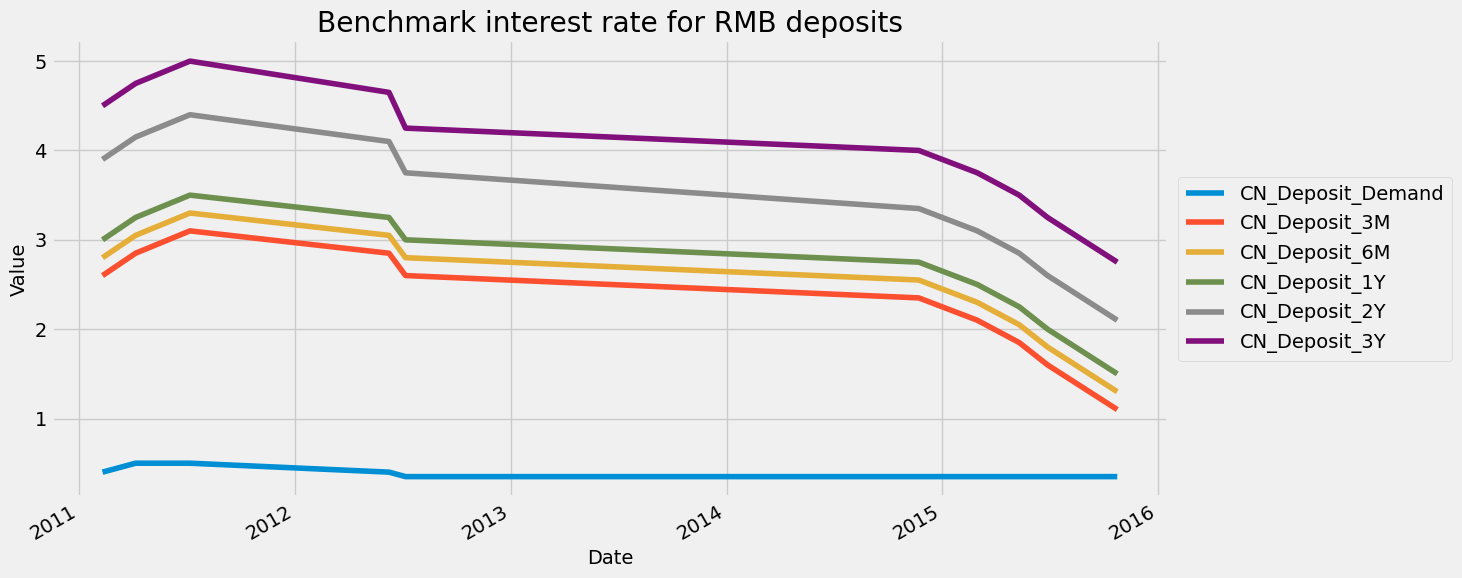

In [14]:
plot_features(deposit_benchmark_df, ['CN_Deposit_Demand', 'CN_Deposit_3M', 'CN_Deposit_6M',
       'CN_Deposit_1Y', 'CN_Deposit_2Y', 'CN_Deposit_3Y'], title="Benchmark interest rate for RMB deposits")

### 存款准备金利率

Interest rate on deposit reserves

In [15]:
raw_deposit_reserve_df = pd.read_excel("./data/features/存款准备金利率.xlsx")
raw_deposit_reserve_df = raw_deposit_reserve_df.rename(columns={
    '指标名称': "Date", 
    '中国:人民银行对金融机构存款利率:法定准备金(月)': "CN_Deposit_Reserve_Legal", 
    '中国:人民银行对金融机构存款利率:超额准备金(月)': "CN_Deposit_Reserve_Excess"
})
raw_deposit_reserve_df

,Date,CN_Deposit_Reserve_Legal,CN_Deposit_Reserve_Excess
0,1996-05-31,8.82,8.82
1,1996-06-30,8.82,8.82
2,1996-07-31,8.82,8.82
3,1996-08-31,8.28,7.92
4,1996-09-30,8.29,7.92
...,...,...,...
317,2022-10-31,1.62,0.35
318,2022-11-30,1.62,0.35
319,2022-12-31,1.62,0.35
320,2023-01-31,1.62,0.35


In [16]:
deposit_reserve_df = clean_data(raw_deposit_reserve_df, date_benchmark, feature_start_date, end_date)
deposit_reserve_df.head()

,Date,CN_Deposit_Reserve_Legal,CN_Deposit_Reserve_Excess
0,2011-01-31,1.62,0.72
1,2011-02-28,1.62,0.72
2,2011-03-31,1.62,0.72
3,2011-04-30,1.62,0.72
4,2011-05-31,1.62,0.72


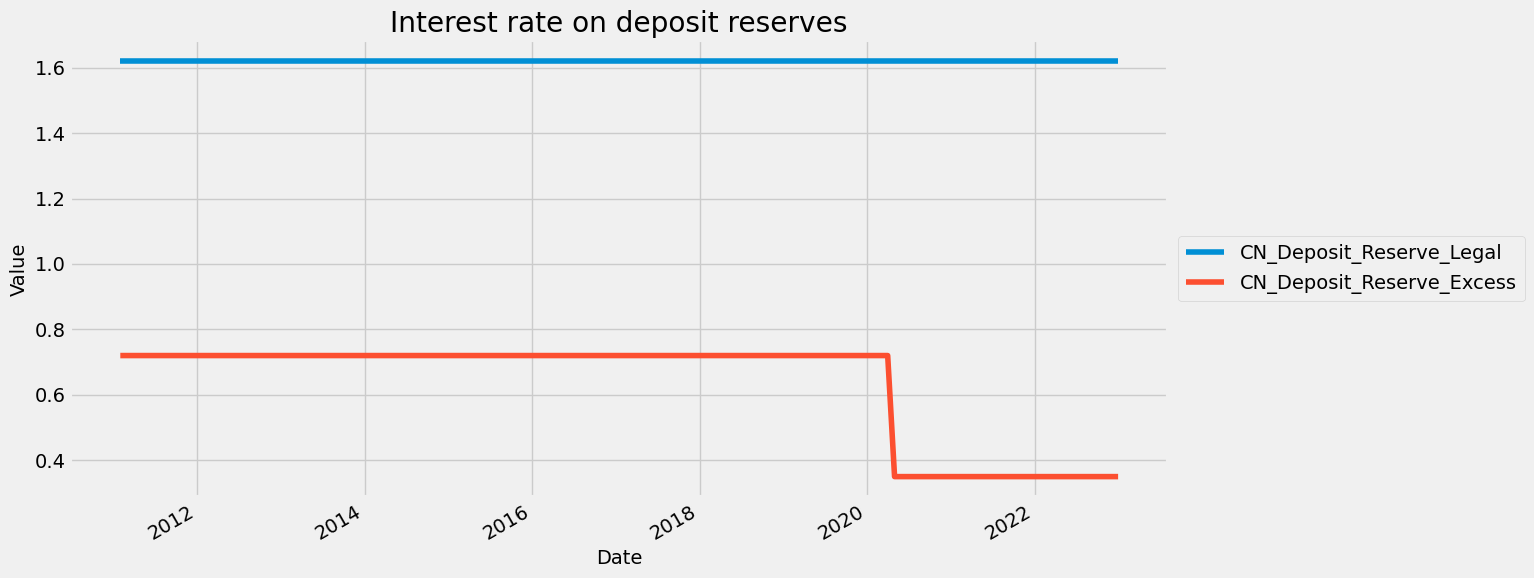

In [17]:
plot_features(deposit_reserve_df, ['CN_Deposit_Reserve_Legal', 'CN_Deposit_Reserve_Excess'], title="Interest rate on deposit reserves")

### 中国固定利率发行利率

China fixed interest rate issue rate

In [18]:
raw_fixed_rate_df = pd.read_excel("./data/features/中国_固定利率国债发行利率.xlsx")
raw_fixed_rate_df = raw_fixed_rate_df.rename(columns={
    '指标名称': "Date", '固定利率国债:发行利率:3个月': "Fixed_Issue_Rate_3M", 
    '固定利率国债:发行利率:6个月': "Fixed_Issue_Rate_6M", '固定利率国债:发行利率:9个月': "Fixed_Issue_Rate_9M",
       '固定利率国债:发行利率:1年': "Fixed_Issue_Rate_1Y", '固定利率国债:发行利率:2年': "Fixed_Issue_Rate_2Y", 
    '固定利率国债:发行利率:3年': "Fixed_Issue_Rate_3Y", '固定利率国债:发行利率:5年': "Fixed_Issue_Rate_5Y",
       '固定利率国债:发行利率:7年': "Fixed_Issue_Rate_7Y", '固定利率国债:发行利率:8年': "Fixed_Issue_Rate_8Y", 
    '固定利率国债:发行利率:10年': "Fixed_Issue_Rate_10Y",
       '固定利率国债:发行利率:15年': "Fixed_Issue_Rate_15Y", '固定利率国债:发行利率:20年': "Fixed_Issue_Rate_20Y", 
    '固定利率国债:发行利率:30年': "Fixed_Issue_Rate_30Y",
       '固定利率国债:发行利率:50年': "Fixed_Issue_Rate_50Y"
})
raw_fixed_rate_df

,Date,Fixed_Issue_Rate_3M,Fixed_Issue_Rate_6M,Fixed_Issue_Rate_9M,Fixed_Issue_Rate_1Y,Fixed_Issue_Rate_2Y,Fixed_Issue_Rate_3Y,Fixed_Issue_Rate_5Y,Fixed_Issue_Rate_7Y,Fixed_Issue_Rate_8Y,Fixed_Issue_Rate_10Y,Fixed_Issue_Rate_15Y,Fixed_Issue_Rate_20Y,Fixed_Issue_Rate_30Y,Fixed_Issue_Rate_50Y
0,1993-03-01,NaN,NaN,NaN,NaN,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-08-16,NaN,NaN,NaN,11.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-02-12,NaN,10.5597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-03-15,9.8392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.830,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,2023-03-03,1.8252,1.9644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1095,2023-03-08,NaN,NaN,NaN,NaN,NaN,2.4857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,2023-03-10,1.8042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.2698,NaN
1097,2023-03-14,NaN,NaN,NaN,NaN,2.35,NaN,NaN,NaN,NaN,2.832,NaN,NaN,NaN,NaN


In [19]:
fixed_rate_df = clean_data(raw_fixed_rate_df, date_benchmark, feature_start_date, end_date)
fixed_rate_df.head()

,Date,Fixed_Issue_Rate_3M,Fixed_Issue_Rate_6M,Fixed_Issue_Rate_9M,Fixed_Issue_Rate_1Y,Fixed_Issue_Rate_2Y,Fixed_Issue_Rate_3Y,Fixed_Issue_Rate_5Y,Fixed_Issue_Rate_7Y,Fixed_Issue_Rate_8Y,Fixed_Issue_Rate_10Y,Fixed_Issue_Rate_15Y,Fixed_Issue_Rate_20Y,Fixed_Issue_Rate_30Y,Fixed_Issue_Rate_50Y
0,2011-01-12,NaN,NaN,NaN,2.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-19,NaN,NaN,NaN,2.81,NaN,NaN,NaN,NaN,NaN,3.94,NaN,NaN,NaN,NaN
2,2011-01-26,NaN,NaN,NaN,2.81,NaN,NaN,NaN,3.83,NaN,3.94,NaN,NaN,NaN,NaN
3,2011-02-16,NaN,NaN,NaN,2.81,NaN,NaN,3.6,3.83,NaN,3.94,NaN,NaN,NaN,NaN
4,2011-02-23,NaN,NaN,NaN,2.81,NaN,NaN,3.6,3.83,NaN,3.94,NaN,NaN,4.31,NaN


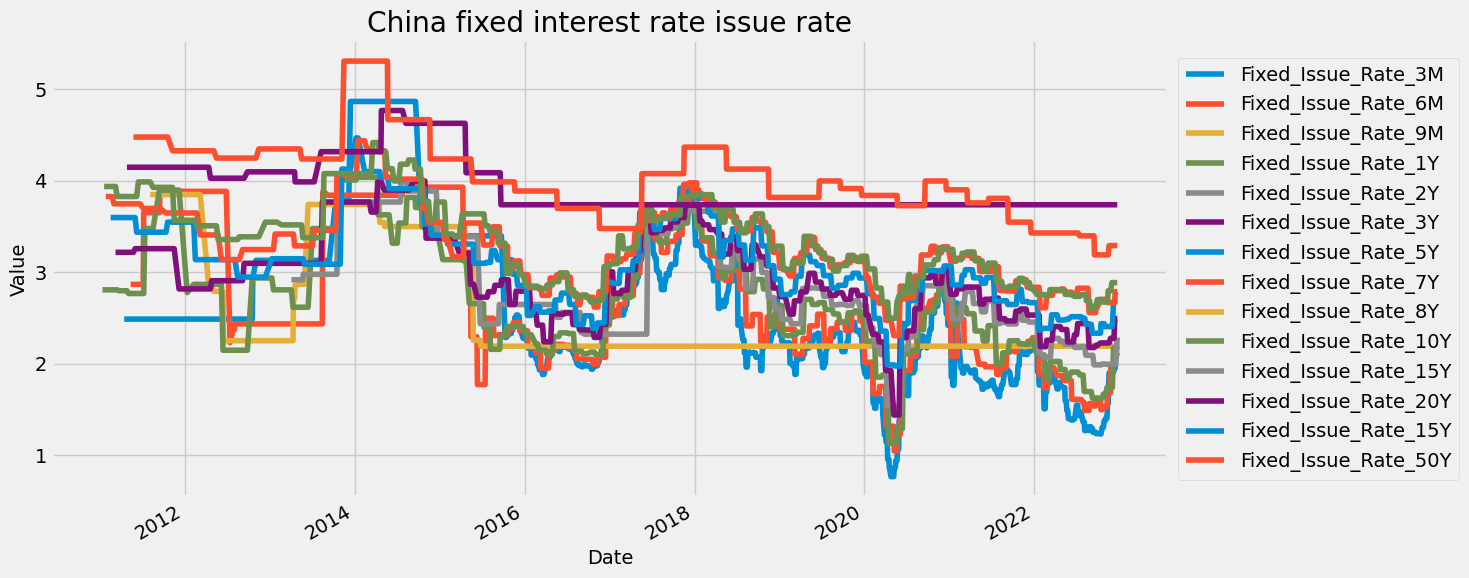

In [20]:
plot_features(fixed_rate_df, ['Fixed_Issue_Rate_3M', 'Fixed_Issue_Rate_6M',
       'Fixed_Issue_Rate_9M', 'Fixed_Issue_Rate_1Y', 'Fixed_Issue_Rate_2Y',
       'Fixed_Issue_Rate_3Y', 'Fixed_Issue_Rate_5Y', 'Fixed_Issue_Rate_7Y',
       'Fixed_Issue_Rate_8Y', 'Fixed_Issue_Rate_10Y', 'Fixed_Issue_Rate_15Y',
       'Fixed_Issue_Rate_20Y', 'Fixed_Issue_Rate_15Y', 'Fixed_Issue_Rate_50Y'], title="China fixed interest rate issue rate")

### 贷款市场报价利率

loan rate

In [21]:
raw_loan_rate = pd.read_excel("./data/features/贷款市场报价利率(LPR).xlsx")
raw_loan_rate = raw_loan_rate.rename(columns={
    '指标名称': 'Date', '中国:贷款市场报价利率(LPR):1年': "LPR_1Y", '中国:贷款市场报价利率(LPR):5年': "LPR_5Y",
       '中国:人民银行对金融机构贷款利率:20天以内': "Loan_Fin_20D", '中国:人民银行对金融机构贷款利率:3个月以内': "Loan_Fin_3M",
       '中国:人民银行对金融机构贷款利率:6个月以内': "Loan_Fin_6M", 
    '中国:人民银行对金融机构贷款利率:1年': "Loan_Fin_1Y", '中国:金融机构人民币贷款加权平均利率': "Loan_Fin_Rate",
       '中国:美元贷款利率:3个月以内': "Loan_CN_USD_3M", '中国:美元贷款利率:3-6个月': "Loan_CN_USD_3_6M", 
    '中国:美元贷款利率:6-12个月': "Loan_CN_USD_6_12M",
       '中国:美元贷款利率:1年(固定)': "Loan_CN_USD_1Y", '中国:美元贷款利率:1年以上': "Loan_CN_USD_1Y_Up"
})
raw_loan_rate

,Date,LPR_1Y,LPR_5Y,Loan_Fin_20D,Loan_Fin_3M,Loan_Fin_6M,Loan_Fin_1Y,Loan_Fin_Rate,Loan_CN_USD_3M,Loan_CN_USD_3_6M,Loan_CN_USD_6_12M,Loan_CN_USD_1Y,Loan_CN_USD_1Y_Up
0,1996-05-01,NaN,NaN,9.00,10.08,10.17,10.98,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-08-23,NaN,NaN,9.00,9.72,10.17,10.62,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-10-23,NaN,NaN,8.55,8.82,9.09,9.36,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-03-21,NaN,NaN,6.39,6.84,7.02,7.92,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-07-01,NaN,NaN,5.22,5.49,5.58,5.67,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,2022-12-31,NaN,4.3,NaN,NaN,NaN,NaN,4.14,5.03,4.99,5.28,5.18,5.67
1697,2023-01-20,3.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1698,2023-01-31,NaN,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1699,2023-02-20,3.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
loan_rate = clean_data(raw_loan_rate, date_benchmark, feature_start_date, end_date)
loan_rate.head()

,Date,LPR_1Y,LPR_5Y,Loan_Fin_20D,Loan_Fin_3M,Loan_Fin_6M,Loan_Fin_1Y,Loan_Fin_Rate,Loan_CN_USD_3M,Loan_CN_USD_3_6M,Loan_CN_USD_6_12M,Loan_CN_USD_1Y,Loan_CN_USD_1Y_Up
0,2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.76,2.92,3.04,2.91,3.35
1,2011-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.94,3.16,3.12,3.16,3.16
2,2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,6.91,3.04,3.26,3.76,3.25,3.15
3,2011-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.91,3.02,3.25,3.57,3.41,3.16
4,2011-05-31,NaN,NaN,NaN,NaN,NaN,NaN,6.91,3.12,3.44,3.68,3.54,3.60


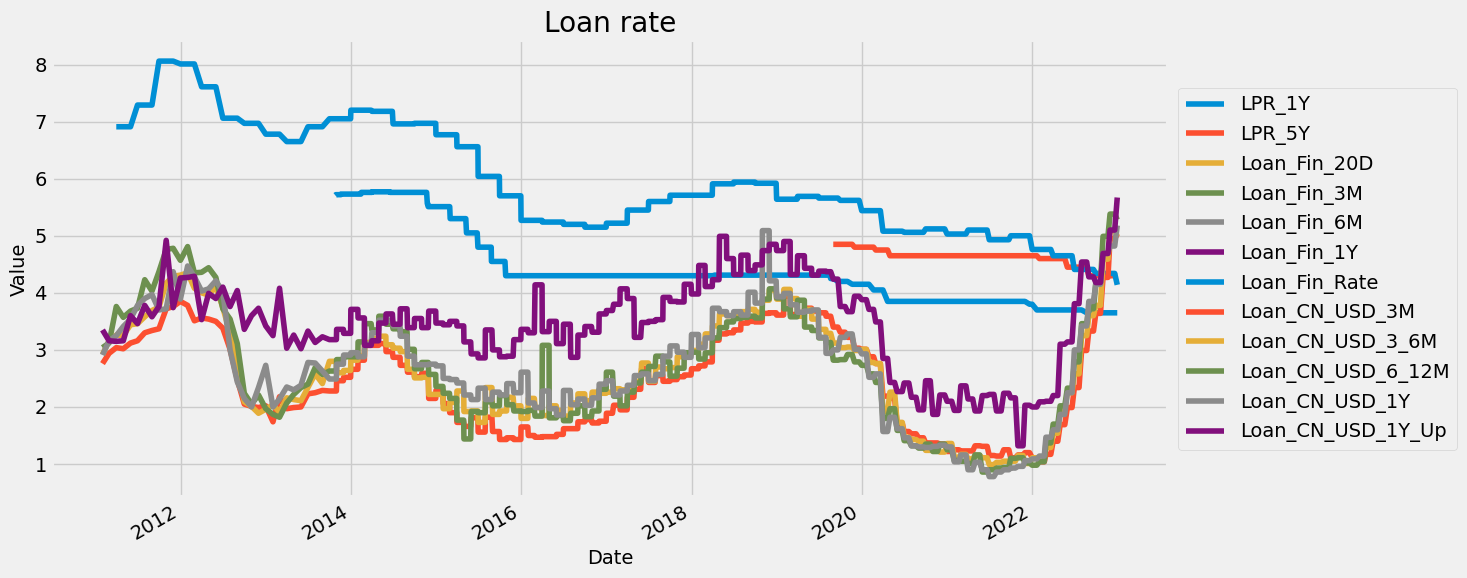

In [23]:
plot_features(loan_rate, [ 'LPR_1Y', 'LPR_5Y', 'Loan_Fin_20D', 'Loan_Fin_3M',
       'Loan_Fin_6M', 'Loan_Fin_1Y', 'Loan_Fin_Rate', 'Loan_CN_USD_3M',
       'Loan_CN_USD_3_6M', 'Loan_CN_USD_6_12M', 'Loan_CN_USD_1Y',
       'Loan_CN_USD_1Y_Up'], title="Loan rate")

In [24]:
#Monetary and fiscal policy
result_df = date_benchmark
from functools import reduce
data_frames = [currency_df, deposit_benchmark_df, deposit_reserve_df, fixed_rate_df, loan_rate]
for temp in data_frames:
    result_df = result_df.merge(temp, on="Date", how="left")
result_df

,Date,CN_M0,CN_M0_MOM,CN_M1,CN_M1_MOM,CN_M2,CN_M2_MOM,CN_SFS_M,CN_SSFS,CN_SSFS_MOM,...,Loan_Fin_20D,Loan_Fin_3M,Loan_Fin_6M,Loan_Fin_1Y,Loan_Fin_Rate,Loan_CN_USD_3M,Loan_CN_USD_3_6M,Loan_CN_USD_6_12M,Loan_CN_USD_1Y,Loan_CN_USD_1Y_Up
0,2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2989,2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2990,2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2991,2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
result_df.to_csv("./data/clean_features/features_monetary_fiscal.csv", index=False, encoding="utf-8-sig")

In [26]:
result_df.describe()

,CN_M0,CN_M0_MOM,CN_M1,CN_M1_MOM,CN_M2,CN_M2_MOM,CN_SFS_M,CN_SSFS,CN_SSFS_MOM,CN_Deposit_Demand,...,Loan_Fin_20D,Loan_Fin_3M,Loan_Fin_6M,Loan_Fin_1Y,Loan_Fin_Rate,Loan_CN_USD_3M,Loan_CN_USD_3_6M,Loan_CN_USD_6_12M,Loan_CN_USD_1Y,Loan_CN_USD_1Y_Up
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,91.000000,91.000000,7.000000,...,0.0,0.0,0.0,0.0,1541.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000
mean,68173.127730,7.722000,451936.094042,8.836000,1.571424e+06,11.446000,18276.444579,191.359031,13.824742,0.407143,...,NaN,NaN,NaN,NaN,5.958352,2.475826,2.704284,2.712631,2.848594,3.697712
std,14530.601043,5.893818,136267.536328,6.006419,5.517939e+05,2.435612,10064.159571,84.579869,3.024811,0.067259,...,NaN,NaN,NaN,NaN,0.709764,0.770760,0.710616,0.734623,0.726587,0.613419
min,44477.800000,-13.800000,259200.500000,0.400000,7.338848e+05,8.000000,2737.000000,76.747800,10.000000,0.350000,...,NaN,NaN,NaN,NaN,4.340000,1.040000,0.990000,0.860000,0.780000,1.320000
25%,58262.960000,4.375000,318788.312500,4.475000,1.099239e+06,8.975000,10868.250000,107.457500,11.012500,0.350000,...,NaN,NaN,NaN,NaN,5.450000,1.740000,2.150000,2.020000,2.280000,3.310000
50%,67053.360000,6.600000,470426.095000,6.550000,1.524959e+06,11.600000,16594.269084,193.969614,12.900000,0.400000,...,NaN,NaN,NaN,NaN,5.710000,2.520000,2.640000,2.780000,2.750000,3.530000
75%,79580.342500,10.350000,561145.561200,12.700000,1.960810e+06,13.300000,23190.937589,263.745000,17.500000,0.450000,...,NaN,NaN,NaN,NaN,6.560000,3.110000,3.280000,3.350000,3.420000,4.150000
max,99740.120000,42.500000,674374.810000,25.300000,2.647008e+06,17.200000,51926.000000,343.190000,19.100000,0.500000,...,NaN,NaN,NaN,NaN,8.060000,4.950000,5.090000,5.380000,5.090000,5.100000
